# Semantic Textual Similarity for Korean


## Import data

In [179]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [180]:
import pandas as pd
import torch
import numpy as np
import random
import os

In [181]:
# seed
seed = 7777
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [182]:
# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla T4
cuda


### Given data

In [183]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [184]:
cd "/content/drive/MyDrive/NLP_project"

/content/drive/MyDrive/NLP_project


In [185]:
_CUR_DIR = os.path.abspath(os.curdir)
print(f"My current directory : {_CUR_DIR}")
_DATA_DIR = os.path.join(_CUR_DIR, "klue-sts-v1.1")

My current directory : /content/drive/MyDrive/NLP_project


In [186]:
df_train0 = pd.read_json('./klue-sts-v1.1/klue-sts-v1.1_train.json')
df_test0 = pd.read_json('./klue-sts-v1.1/klue-sts-v1.1_dev.json')

In [187]:
print(df_train0.shape, df_test.shape)
print(df_train0.columns)
print(df_test.columns)

(11668, 6) (519, 2)
Index(['guid', 'source', 'sentence1', 'sentence2', 'labels', 'annotations'], dtype='object')
Index(['sentence', 'label'], dtype='object')


### Collected data

### Visualization

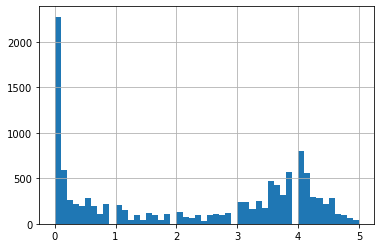

In [188]:
df_train0['labels'].map(lambda x: x['real-label']).hist(bins=50)

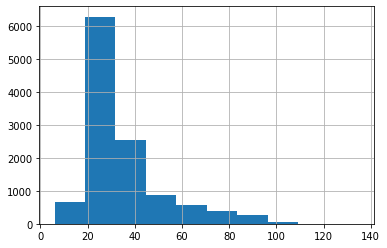

In [189]:
df_train0['sentence1'].map(lambda x: len(x)).hist()

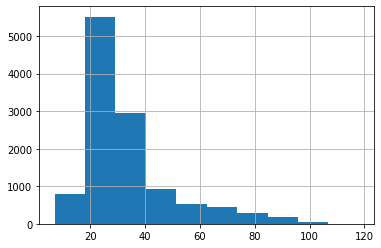

In [190]:
df_train0['sentence2'].map(lambda x: len(x)).hist()

## Data preprocess

In [191]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import BertTokenizer

### Preprocess

In [217]:
class Preprocess:
    def __init__(self,train,test):
        self.train=train
        self.test=test

    def BERT_baseline(self):
        sentence = self.train.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
        label = self.train['labels'].map(lambda x: round(x['real-label']))
        train = pd.concat([sentence,label],axis=1)
        train.columns = ['sentence','label']
        sentence = self.test.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
        label = self.test['labels'].map(lambda x: round(x['real-label']))
        test = pd.concat([sentence,label],axis=1)
        test.columns = ['sentence','label']
        return train, test

    def BERT_floor(self):
        sentence = self.train.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
        label = self.train['labels'].map(lambda x: int(x['real-label']))
        train = pd.concat([sentence,label],axis=1)
        train.columns = ['sentence','label']
        sentence = self.test.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
        label = self.test['labels'].map(lambda x: int(x['real-label']))
        test = pd.concat([sentence,label],axis=1)
        test.columns = ['sentence','label']
        return train, test

In [218]:
pp=Preprocess(df_train0,df_test0)

In [194]:
df_train, df_test = pp.BERT_baseline()

In [219]:
df_train, df_test = pp.BERT_floor()

In [220]:
df_train.head()

,sentence,label
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다. [SEP] 숙박시설의 위...,3
1,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다. ...,0
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘. [SEP] ...,0
3,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...",0
4,"호스트의 답장이 늦으나, 개선될 것으로 보입니다. [SEP] 호스트 응답이 늦었지만...",4


In [229]:
df_train['label'].value_counts()

0    4350
3    2852
4    2705
1     906
2     810
5      45
Name: label, dtype: int64

### Augmentation

### Dataset

In [230]:
# Custom Dataset
class CustomDataset(Dataset):
    """
    - input_data: list of string
    - target_data: list of int
    """
    
    def __init__(self, input_data:list, target_data:list) -> None:
        self.X = input_data
        self.Y = target_data
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [231]:
train_dataset = CustomDataset(df_train.sentence.to_list(), df_train.label.to_list())
test_dataset = CustomDataset(df_test.sentence.to_list(), df_test.label.to_list())
print(f"Train Dataset len: {len(train_dataset)}")
print(f"Train Dataset 1st element: {train_dataset[0]}")

print(f"Test Dataset len: {len(test_dataset)}")
print(f"Test Dataset 1st element: {test_dataset[0]}")

Train Dataset len: 11668
Train Dataset 1st element: ('숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다. [SEP] 숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.', 3)
Test Dataset len: 519
Test Dataset 1st element: ('무엇보다도 호스트분들이 너무 친절하셨습니다. [SEP] 무엇보다도, 호스트들은 매우 친절했습니다.', 4)


### DataLoader

In [232]:
n_sample = df_train.shape[0]
n_train = int(n_sample*0.9)
n_valid = n_sample-n_train
train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_valid])

print(f"Train dataset len: {len(train_dataset)}")
print(f"Valid dataset len: {len(valid_dataset)}")

Train dataset len: 10501
Valid dataset len: 1167


In [233]:
# Custom collate_fn 
def custom_collate_fn(batch):
    """
    한 배치 내 문장들을 tokenizing 한 후 텐서로 변환함. 
    이때, dynamic padding (즉, 같은 배치 내 토큰의 개수가 동일할 수 있도록, 부족한 문장에 [PAD] 토큰을 추가하는 작업)을 적용
    
    한 배치 내 레이블(target)은 텐서화 함.
    
    - batch: list of tuples (input_data(string), target_data(int))
    """
    input_list, target_list = [], []

    tokenizer_bert = BertTokenizer.from_pretrained("klue/bert-base")
    
    for _input, _target in batch:
        input_list.append(_input)
        target_list.append(_target)
    
    tensorized_input = tokenizer_bert(
        input_list,
        add_special_tokens=True,
        padding="longest", # 배치내 가장 긴 문장을 기준으로 부족한 문장은 [PAD] 토큰을 추가
        truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
        max_length=512,
        return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
    )
    
    tensorized_label = torch.tensor(target_list)
    
    return tensorized_input, tensorized_label

In [234]:
# DataLoader 구현
train_batch_size = 32
valid_batch_size = 64

train_dataloader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    sampler = RandomSampler(train_dataset),
    collate_fn = custom_collate_fn
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = valid_batch_size,
    sampler = SequentialSampler(valid_dataset),
    collate_fn = custom_collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = valid_batch_size,
    sampler = SequentialSampler(test_dataset),
    collate_fn = custom_collate_fn
)
print(f"Train dataloader # steps: {len(train_dataloader)}")
print(f"Valid dataloader # steps: {len(valid_dataloader)}")
print(f"Test dataloader # steps: {len(test_dataloader)}")

Train dataloader # steps: 329
Valid dataloader # steps: 19
Test dataloader # steps: 9


## Model

In [235]:
from transformers import BertModel, BertForSequenceClassification
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
from transformers import get_linear_schedule_with_warmup, get_constant_schedule

### Initializer

In [236]:
def initializer(train_dataloader, epochs=2):
    """
    모델, 옵티마이저, 스케쥴러 초기화
    """
    
    model = CustomClassifier(hidden_size=768, n_label=6)

    optimizer = AdamW(
        model.parameters(), # update 대상 파라미터를 입력
        lr=2e-5,
        eps=1e-8
    )
    
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0, # 여기서는 warmup을 사용하지 않는다.
        num_training_steps = total_steps
    )

    return model, optimizer, scheduler

### save_checkpoint

In [237]:
def save_checkpoint(path, model, optimizer, scheduler, epoch, loss):
    file_name = f'{path}/model.ckpt.{epoch}'
    
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}")

### validate

In [238]:
def validate(model, valid_dataloader):
   
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc= 0,0
        
    for step, batch in enumerate(valid_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
            
        # gradient 계산하지 않음
        with torch.no_grad():
            logits = model(**batch_input)
            
        # loss
        loss = loss_fct(logits, batch_label)
        total_loss += loss.item()
        
        # accuracy
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).flatten()
        acc = (preds == batch_label).cpu().numpy().mean()
        total_acc+=acc
    
    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)*100

    return total_loss, total_acc

### Custom Models

#### BERT/baseline

In [239]:
# Custom Classifer
class CustomClassifier(nn.Module):

    def __init__(self, hidden_size: int, n_label: int, freeze_base: bool = False):
        super(CustomClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("klue/bert-base")

        if freeze_base:
            for param in self.bert.parameters():
                param.requires_grad=False

        dropout_rate = 0.1
        linear_layer_hidden_size = 6

        self.classifier = nn.Sequential(
        nn.Linear(hidden_size, linear_layer_hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(linear_layer_hidden_size, n_label)
        )

    

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        last_hidden_states = outputs[0] # last hidden states (batch_size, sequence_len, hidden_size)
        cls_token_last_hidden_states = last_hidden_states[:,0,:] # (batch_size, first_token, hidden_size)

        logits = self.classifier(cls_token_last_hidden_states)

        return logits

#### BERT/BertForSequenceClassification

In [206]:
# Custom Classifer
class CustomClassifier(nn.Module):

    def __init__(self, hidden_size: int, n_label: int, freeze_base: bool = False):
        super(CustomClassifier, self).__init__()

        self.bert = BertForSequenceClassification.from_pretrained("klue/bert-base")

        if freeze_base:
            for param in self.bert.parameters():
                param.requires_grad=False

        dropout_rate = 0.1
        linear_layer_hidden_size = 6

        self.classifier = nn.Sequential(
        nn.Linear(hidden_size, linear_layer_hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(linear_layer_hidden_size, n_label)
        )

    

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        last_hidden_states = outputs[0] # last hidden states (batch_size, sequence_len, hidden_size)
        cls_token_last_hidden_states = last_hidden_states[:,0,:] # (batch_size, first_token, hidden_size)

        logits = self.classifier(cls_token_last_hidden_states)

        return logits

### Train

In [240]:
def train_model(model, train_dataloader, valid_dataloader=None, epochs=2):
        
        # train_dataloaer 학습을 epochs만큼 반복
        for epoch in range(epochs):
            print(f"*****Epoch {epoch} Train Start*****")
            
            # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
            total_loss, batch_loss, batch_count = 0,0,0
        
            # model을 train 모드로 설정 & device 할당
            model.train()
            model.to(device)
            
            # data iterator를 돌면서 하나씩 학습
            for step, batch in enumerate(train_dataloader):
                batch_count+=1
                
                # tensor 연산 전, 각 tensor에 device 할당
                batch = tuple(item.to(device) for item in batch)
            
                batch_input, batch_label = batch
            
                # batch마다 모델이 갖고 있는 기존 gradient를 초기화
                model.zero_grad()
            
                # forward
                logits = model(**batch_input)
            
                # loss
                loss = loss_fct(logits, batch_label)
                batch_loss += loss.item()
                total_loss += loss.item()
            
                # backward -> 파라미터의 미분(gradient)를 자동으로 계산
                loss.backward()
                
                # gradient clipping 적용 
                clip_grad_norm_(model.parameters(), 1.0)
                
                # optimizer & scheduler 업데이트
                optimizer.step()
                scheduler.step()
                
                # 배치 10개씩 처리할 때마다 평균 loss와 lr를 출력
                if (step % 10 == 0 and step != 0):
                    learning_rate = optimizer.param_groups[0]['lr']
                    print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate}, Avg Loss : {batch_loss / batch_count:.4f}")

                    # reset 
                    batch_loss, batch_count = 0,0
            
            print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
            print(f"*****Epoch {epoch} Train Finish*****\n")
            
            if valid_dataloader is not None:
                print(f"*****Epoch {epoch} Valid Start*****")
                valid_loss, valid_acc = validate(model, valid_dataloader)
                print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.2f}")
                print(f"*****Epoch {epoch} Valid Finish*****\n")
            
            # checkpoint 저장
            save_checkpoint(".", model, optimizer, scheduler, epoch, total_loss/(step+1))
                
        print("Train Completed. End Program.")

In [241]:
loss_fct = CrossEntropyLoss()
epochs=4
model, optimizer, scheduler = initializer(train_dataloader, epochs)
train_model(model, train_dataloader, valid_dataloader, epochs)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1316
*****Epoch 0 Train Start*****
Epoch: 0, Step : 10, LR : 1.9832826747720366e-05, Avg Loss : 1.6091
Epoch: 0, Step : 20, LR : 1.968085106382979e-05, Avg Loss : 1.5229
Epoch: 0, Step : 30, LR : 1.952887537993921e-05, Avg Loss : 1.5430
Epoch: 0, Step : 40, LR : 1.9376899696048635e-05, Avg Loss : 1.5405
Epoch: 0, Step : 50, LR : 1.922492401215806e-05, Avg Loss : 1.4104
Epoch: 0, Step : 60, LR : 1.9072948328267476e-05, Avg Loss : 1.4144
Epoch: 0, Step : 70, LR : 1.89209726443769e-05, Avg Loss : 1.4123
Epoch: 0, Step : 80, LR : 1.8768996960486324e-05, Avg Loss : 1.4046
Epoch: 0, Step : 90, LR : 1.8617021276595745e-05, Avg Loss : 1.3446
Epoch: 0, Step : 100, LR : 1.846504559270517e-05, Avg Loss : 1.3383
Epoch: 0, Step : 110, LR : 1.8313069908814593e-05, Avg Loss : 1.3015
Epoch: 0, Step : 120, LR : 1.8161094224924014e-05, Avg Loss : 1.3150
Epoch: 0, Step : 130, LR : 1.8009118541033438e-05, Avg Loss : 1.2733
Epoch: 0, Step : 140, LR : 1.785714285714286e-05, 

## Evaluation

Load checkpoint

In [243]:
best_epoch = input()
checkpoint = torch.load(f'./model.ckpt.{best_epoch}')

2


In [244]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss'])

In [258]:
epochs=1
model, optimizer, scheduler = initializer(train_dataloader, epochs)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 329


In [259]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

predict and evaluate

In [247]:
def predict(model, test_dataloader):
    """
    test_dataloader의 label별 확률값과 실제 label 값을 반환
    """

    model.eval()
    model.to(device)

    all_logits = []
    all_labels = []

    for step, batch in enumerate(test_dataloader):
        print(f"{step}/{len(test_dataloader)}")
        
        batch_input, batch_label = batch
        
        batch_input = batch_input.to(device)
        
        with torch.no_grad():
            logits = model(**batch_input)
            all_logits.append(logits)
        all_labels.extend(batch_label)

    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    all_labels = np.array(all_labels)

    return probs, all_labels


In [248]:
probs, labels = predict(model, test_dataloader)

0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9


In [249]:
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import pearsonr
def evaluate(pred, test=df_test0):
    pred_binary = list(map(lambda x: 1 if x>=3 else 0, pred))
    test_real_label = test['labels'].map(lambda x: x['real-label'])
    test_binary_label = test['labels'].map(lambda x: x['binary-label'])
    print(f'acc : {accuracy_score(test_binary_label, pred_binary)}')
    print(f'f1 : {f1_score(test_binary_label, pred_binary)}')
    print(f'pearson : {pearsonr(test_real_label, pred)}')
    

In [250]:
evaluate(labels)

acc : 1.0
f1 : 1.0
pearson : (0.9819793453996939, 0.0)


output

In [251]:
output = pd.DataFrame(labels,columns=['pred_real_label'])
filename = input()
output.to_csv(f'{filename}.csv')

second_test


In [256]:
df_test['sentence'][0]

'무엇보다도 호스트분들이 너무 친절하셨습니다. [SEP] 무엇보다도, 호스트들은 매우 친절했습니다.'

In [260]:
text = df_test['sentence'][0]
tokenizer_bert = BertTokenizer.from_pretrained("klue/bert-base")

tensorized_input = tokenizer_bert(
    text,
    add_special_tokens=True,
    padding="longest", 
    truncation=True, 
    max_length=512,
    return_tensors='pt' 
)
tensorized_input.to(device)
model.eval()
model.to(device)
traced_model = torch.jit.trace(model, tensorized_input['input_ids'])
torch.jit.save(traced_model, "model_scripted.pt")

In [261]:
model = torch.jit.load('model_scripted.pt')

In [262]:
model(tensorized_input['input_ids'])

tensor([[-4.1509,  0.7839, -1.1482, -2.2241,  2.3314, -2.9184]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [257]:
df_test['label'][0]

4